# Portafolios de Inversión
## Repaso Práctico
José Armando Melchor Soto

---





### Librerías 

In [37]:
import pandas as pd 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize 

---

#### Funciones

##### Función Mínima Varianza 

In [38]:
def opt_min_var(rets):
    
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    var = lambda w: w.T @ cov @ w
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=var, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Máximo de Sharpe

In [39]:
def opt_max_sharpe(rets, rf):
    
    E=rets.mean()
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    rs = lambda w: -((w.T @ E - rf/252) / np.sqrt(w.T @ cov @ w))
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=rs, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Semi-Varianza Target

In [40]:
def objetivo (rets:pd.DataFrame , rets_b : pd.DataFrame ,corr:pd.DataFrame):
    
    rets, rets_b = rets.align(rets_b, join='inner', axis=0)
    diffs=rets - rets_b.values
    rends_below_bench = diffs[diffs < 0].fillna(0)
    target_downside_risk=np.array(rends_below_bench.std())
    target_semivarmatrix= corr * (target_downside_risk.reshape(len(rets.columns), 1) @ target_downside_risk.reshape(1, len(rets.columns)))

    objectivo = lambda w: (w.T @ target_semivarmatrix @ w)

    n = len(rets.keys())
    w_inicial = np.ones(n)/n
    bounds = [(0,1)]*n
    tol = 1e-9
    rest = lambda w: np.sum(w) - 1
    
    obj = minimize(
    fun=objectivo,
    x0=w_inicial,
    bounds=bounds,
    constraints={'fun': rest, 'type': 'eq'},
    tol=tol)

    w_objetivo = obj.x

    return dict(zip(rets.columns, w_objetivo))

#### Función de Backtesting

In [41]:
def backtesting(prices: pd.DataFrame, benchmark: pd.DataFrame, weights: dict, capital: float):
    
    # Obtener rendimientos de precios y benchmark
    rets_assets = prices.pct_change().dropna()
    rets_benchmark = benchmark.pct_change().dropna()
    
    # data frame vacio para llenar historia
    
    df = pd.DataFrame(index=rets_assets.index)
    
    # Obtener evolución para cada estrategia dada
    for strategy in weights.keys():
        # para benchmark
        if strategy == 'benchmark':
            temp = rets_benchmark + 1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values            
    
        # para otras estrategias

        else:
            temp = (rets_assets * weights.get(strategy)).sum(axis=1)+1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values    

    # Graficar la evolucion para ambos portafolios
    plt.figure(figsize=(12,6))
    plt.plot(df, label=df.keys())
    plt.title('Backtesting of Strategies')
    plt.xlabel('Date')
    plt.ylabel('Portafolio Value')
    plt.legend()
    plt.show()


    return df

##### Función Metricas de Desempeño

In [42]:
def metrics(history, rf):
    # Returns
    rets= history.pct_change().dropna()
    
    # Matriz de Cov
    cov_hist = rets.cov()

    # Dataframe
    metricas = pd.DataFrame(index=rets.columns)

    # Rendimiento 
    metricas['Rendimiento Promedio Anual'] = R_p = rets.mean()*252*100
    
    # Volatilidad 
    metricas['Volatilidad Anual'] = vol_anual = rets.std()*np.sqrt(252)*100
    
    # Ratio de Sharpe
    metricas['Ratio de Sharpe'] = (R_p - rf) / vol_anual

    # Downside Risk
    metricas['Downside Risk'] = downside = rets[rets < 0].std() * np.sqrt(252) * 100

    # Upside Risk
    metricas['Upside Risk'] = upside = rets[rets > 0].std() * np.sqrt(252) * 100

    # Omega
    metricas['Omega'] =omega= upside / downside

    # Beta

    covs = cov_hist['Benchmark']
    varianza_market = covs['Benchmark']
    metricas['Beta'] = beta = covs / varianza_market

    # Alfa de Jensen

    R_m = rets['Benchmark']
    alpha_Jensen = R_p - (rf + beta * (R_m - rf))

    # Ratio de Treynor
    metricas['Ratio de Treynor'] = (R_p - rf) / beta

    # Ratio de Sortino
    metricas['Ratio de Sortino'] = (R_p - rf) / downside

    return metricas.T


---

#### Importación de Datos

In [43]:
tickers = ['PG', 'COST', 'KO', 'WMT', 'CLX', 'K', 'KHC']

opt_prices = yf.download(tickers, start='2023-06-23', end='2024-06-23', progress=False)['Close']

bt_prices = yf.download(tickers,  start='2024-06-23', end='2025-06-23', progress=False)['Close']

benchmark = yf.download(['KXI'], start='2024-06-23', end='2025-06-23', progress=False)['Close']

In [44]:
rets = opt_prices.pct_change().dropna()
rets_b = benchmark.pct_change().dropna()
rets_bt = bt_prices.pct_change().dropna()
corr = rets.corr()

---

#### Mínima Varianza 

In [45]:
w_minvar = opt_min_var(rets)
w_minvar

array([3.27863937e-18, 1.88150786e-01, 1.02397781e-02, 9.29532376e-02,
       3.13355966e-01, 2.59676124e-01, 1.35624108e-01])

#### Máximo de Sharpe

In [46]:
w_maxsharpe = opt_max_sharpe(rets,0.045)
w_maxsharpe

array([0.00000000e+00, 7.96317216e-01, 9.80380976e-18, 0.00000000e+00,
       0.00000000e+00, 6.85823358e-02, 1.35100449e-01])

#### Semi Varianza Target

In [47]:
w_semivar = objetivo(rets, rets_b, corr)
w_semivar

{'CLX': 0.14285714285714285,
 'COST': 0.14285714285714285,
 'K': 0.14285714285714285,
 'KHC': 0.14285714285714285,
 'KO': 0.14285714285714285,
 'PG': 0.14285714285714285,
 'WMT': 0.14285714285714285}

#### Backtesting

In [48]:
capital = 1000000

In [49]:
w_dict = {
    'Min Varianza': w_minvar,
    'Max Sharpe': w_maxsharpe,
    'Semi-Varianza target': w_semivar,
    'Benchmark': 1
}

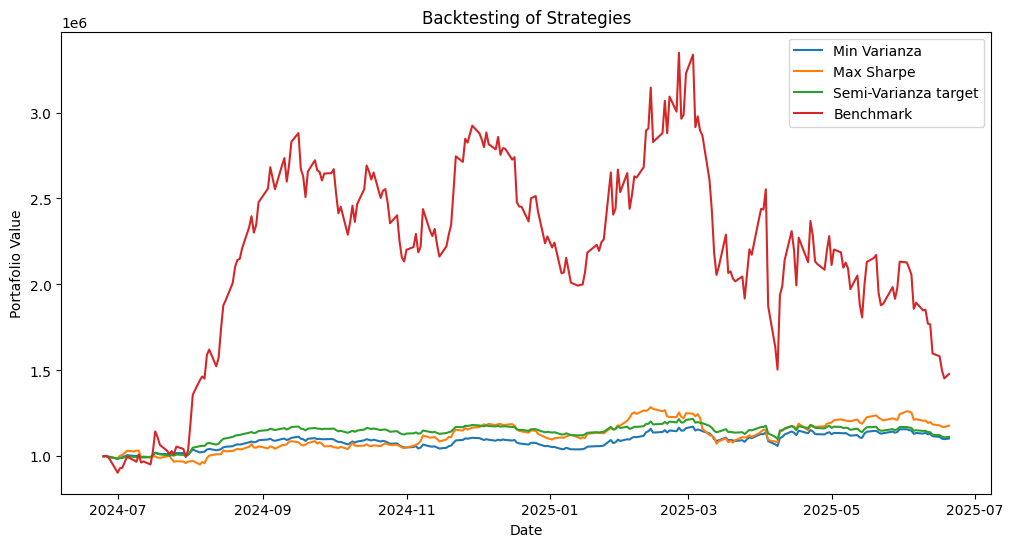

In [50]:
history = backtesting(bt_prices, benchmark, w_dict, capital)

In [51]:
metricas = metrics(history, 0.045)
metricas

,Min Varianza,Max Sharpe,Semi-Varianza target,Benchmark
Rendimiento Promedio Anual,11.106582,18.893862,11.797804,82.584627
Volatilidad Anual,14.577251,20.741553,13.219401,92.535809
Ratio de Sharpe,0.758825,0.908749,0.889057,0.891975
Downside Risk,9.481215,14.810675,8.438355,59.068484
Upside Risk,9.954781,13.835130,9.238396,64.668774
Omega,1.049948,0.934132,1.094810,1.094810
Beta,0.148877,0.153238,0.142857,1.000000
Ratio de Treynor,74.300022,123.003722,82.269627,82.539627
Ratio de Sortino,1.166684,1.272654,1.392784,1.397355


In [52]:
re_opt = pd.DataFrame(index=rets.columns)
re_opt['w'] = opt_min_var(rets_bt)
re_opt['Cash'] = re_opt['w'] * capital
re_opt['No. Acciones'] = np.floor(re_opt['Cash'] / bt_prices.iloc[-1])
re_opt

,w,Cash,No. Acciones
Ticker,,,
CLX,0.045780,45780.126092,379.0
COST,0.184887,184887.314059,188.0
K,0.327643,327643.109077,4164.0
KHC,0.068202,68201.650784,2643.0
KO,0.291148,291148.043998,4229.0
PG,0.048375,48375.449193,304.0
WMT,0.033964,33964.306796,353.0


---

#### Con diferentes activos

In [53]:
tickers = ['LLY', 'ISRG', 'ABBV', 'JNJ', 'MRK']

In [54]:
opt_prices = yf.download(tickers, start='2023-06-23', end='2024-06-23', progress=False)['Close']

bt_prices = yf.download(tickers,  start='2024-06-23', end='2025-06-23', progress=False)['Close']

benchmark = yf.download(['KXI'], start='2024-06-23', end='2025-06-23', progress=False)['Close']

In [55]:
rets = opt_prices.pct_change().dropna()
rets_b = benchmark.pct_change().dropna()
rets_bt = bt_prices.pct_change().dropna()
corr = rets.corr()


---

#### Mínima Varianza 

In [56]:
w_minvar = opt_min_var(rets)

#### Máximo de Sharpe

In [57]:
w_maxsharpe = opt_max_sharpe(rets, 0.045)

#### Semi Varianza Target

In [58]:
w_semivar = objetivo(rets, rets_b, corr)

#### Backtesting

##### Capital

In [59]:
capital = 1000000

In [60]:
w_dict= {
    'Min Var' : w_minvar,
    'Max Sharpe': w_maxsharpe,
    'Semi Var': w_semivar,
    'Benchmark': 1
}

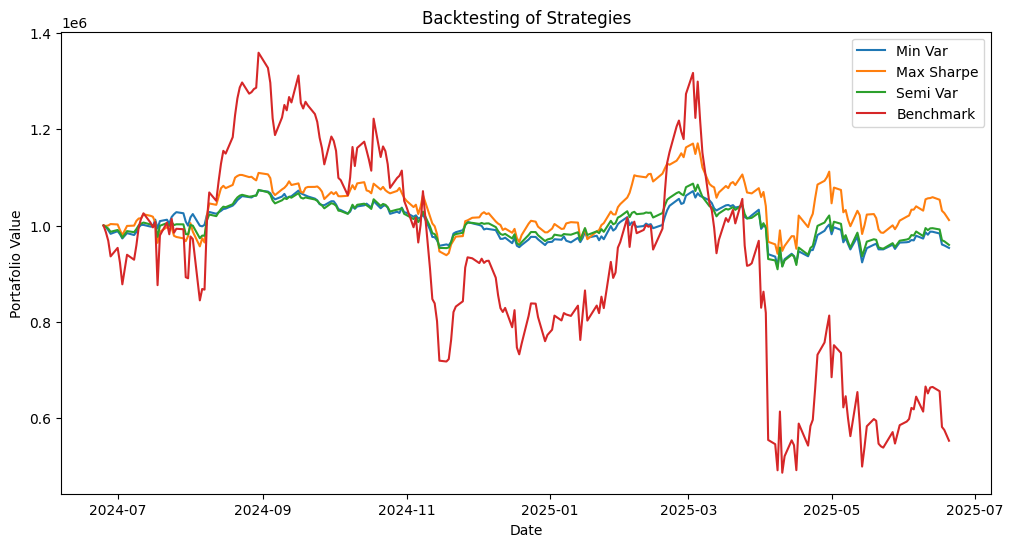

In [61]:
history = backtesting(bt_prices,benchmark, w_dict, capital )

In [62]:
metrics(history, rf= 0.045)


,Min Var,Max Sharpe,Semi Var,Benchmark
Rendimiento Promedio Anual,-3.311087,4.585956,-2.298111,-11.490557
Volatilidad Anual,17.604894,26.242559,19.474770,97.373848
Ratio de Sharpe,-0.190634,0.173038,-0.120315,-0.118467
Downside Risk,14.161066,20.031993,15.183317,75.916584
Upside Risk,9.930753,17.332543,12.534061,62.670306
Omega,0.701272,0.865243,0.825515,0.825515
Beta,0.171365,0.248053,0.200000,1.000000
Ratio de Treynor,-19.584483,18.306360,-11.715557,-11.535557
Ratio de Sortino,-0.236994,0.226685,-0.154321,-0.151950


#### Portafolio Real 

In [63]:
re_opt = pd.DataFrame(index=rets.columns)
re_opt['w'] = opt_min_var(rets_bt)
re_opt['Cash'] = re_opt['w'] * capital
re_opt['No. Acciones'] = np.floor(re_opt['Cash'] / bt_prices.iloc[-1])
re_opt['w'].sum()
re_opt

,w,Cash,No. Acciones
Ticker,,,
ABBV,0.042602,42601.840366,229.0
ISRG,0.207376,207376.347836,407.0
JNJ,0.642457,642456.677171,4289.0
LLY,0.004209,4209.341484,5.0
MRK,0.103356,103355.793144,1307.0
